### University World Rank Prediction

Gary Agasa 24300810019@m.fudan.edu.cn

Import some necessary packages

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#### Part I. Data Processing

##### 1.Read in the `cwurData.csv` as the `pandas` dataframe

In [3]:
df = pd.read_csv('dataset/Rankings16-25.csv')
print(df.shape)
df.head(5)

(14522, 14)


,Rank,Name,Country,Student Population,Students to Staff Ratio,International Students,Female to Male Ratio,Overall Score,Teaching,Research Environment,Research Quality,Industry Impact,International Outlook,Year
0,1.0,California Institute of Technology,United States,2243.0,6.9,26%,33 : 67,95.2,95.6,97.6,99.8,97.8,64.0,2016
1,2.0,University of Oxford,United Kingdom,19920.0,11.6,34%,46:54:00,94.2,86.5,98.9,98.8,73.1,94.4,2016
2,3.0,Stanford University,United States,15596.0,7.8,22%,42:58:00,93.9,92.5,96.2,99.9,63.3,76.3,2016
3,4.0,University of Cambridge,United Kingdom,18810.0,11.8,34%,46:54:00,92.8,88.2,96.7,97.0,55.0,91.5,2016
4,5.0,Massachusetts Institute of Technology,United States,11074.0,9.0,33%,37 : 63,92.0,89.4,88.6,99.7,95.4,84.0,2016


In [4]:
def safe_convert_ratio(ratio_str):
	if isinstance(ratio_str, str) and ':' in ratio_str:
		sexes = ratio_str.split(':')
		female, male = int(sexes[0]), int(sexes[1])
		total = male + female
		return round(female / total, 2) if total > 0 else 0.0
	else:
		return 0.0

df['female_ratio'] = df['Female to Male Ratio'].apply(safe_convert_ratio)
# delete the "Female to Male Ratio" column
df = df.drop('Female to Male Ratio', axis=1)

print(df.shape)
df.sample(5)

(14522, 14)


,Rank,Name,Country,Student Population,Students to Staff Ratio,International Students,Overall Score,Teaching,Research Environment,Research Quality,Industry Impact,International Outlook,Year,female_ratio
7613,549.0,Polytechnic University of Bari,Italy,9639.0,41.5,1%,39.5925,17.3,22.2,79.2,55.5,34.6,2022,0.31
8157,1093.0,The Islamia University of Bahawalpur,Pakistan,29156.0,24.3,0%,24.8325,22.6,10.5,36.7,34.8,40.3,2022,0.38
497,498.0,National Institute of Applied Sciences of Lyon...,France,6137.0,8.2,31%,29.5975,27.0,10.6,41.8,40.3,63.6,2016,0.31
9339,613.0,Prince Sattam Bin Abdulaziz University,Saudi Arabia,27117.0,12.2,2%,38.8650,17.7,9.9,80.4,37.8,73.6,2023,0.58
10676,151.0,Sichuan University,China,49117.0,15.9,5%,62.0270,59.1,57.3,69.3,93.2,46.1,2024,0.00


In [5]:
# Processing International Students ratio
def convert_inter(value):
	if isinstance(value, str) and '%' in value:
		num_str = value.replace('%', '').strip()
        
		if num_str.isdigit():
			return int(num_str) / 100
    	
		elif isinstance(value, (int, float)):
			return int(value) / 100
    	
	# 对于空字符串或其他无效格式，返回 0
	return 0


df['Foreign Students ratio'] = df['International Students'].apply(convert_inter)
# delete the "International Students Column"
df = df.drop('International Students', axis=1)

print(df.shape)
df.sample(5)

(14522, 14)


,Rank,Name,Country,Student Population,Students to Staff Ratio,Overall Score,Teaching,Research Environment,Research Quality,Industry Impact,International Outlook,Year,female_ratio,Foreign Students ratio
10807,282.0,Qatar University,Qatar,10081.0,8.4,54.2495,31.3,35.6,83.4,61.8,96.0,2024,0.77,0.36
7838,774.0,Northern Illinois University,United States,14266.0,15.5,32.4575,27.0,16.2,50.0,35.6,48.1,2022,0.51,0.06
13828,1399.0,Chaoyang University of Technology,Taiwan,13287.0,34.8,27.1205,14.5,21.6,38.1,49.6,42.2,2025,0.59,0.06
6229,691.0,Isfahan University of Technology,Iran,9373.0,21.8,33.4175,30.2,25.9,41.4,91.1,25.2,2021,0.48,0.01
8840,114.0,Université Paris Cité,France,62747.0,17.0,61.7350,51.5,44.8,89.3,37.3,68.3,2023,0.65,0.19


**Feature Engineering**

we encoding the country into one-hot vector, simply delete the name column

In [6]:
df_encoded = pd.get_dummies(df, columns=['Country'], prefix='Country', dtype=int)

df_encoded['name_len'] = df_encoded['Name'].apply(len)
df_encoded['name_of'] = df_encoded['Name'].apply(lambda str : 1 if 'of' in str else 0)
df_encoded = df_encoded.drop('Name', axis=1)
df_encoded.head(5)

,Rank,Student Population,Students to Staff Ratio,Overall Score,Teaching,Research Environment,Research Quality,Industry Impact,International Outlook,Year,...,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_Uzbekistan,Country_Venezuela,Country_Vietnam,Country_Zambia,Country_Zimbabwe,name_len,name_of
0,1.0,2243.0,6.9,95.2,95.6,97.6,99.8,97.8,64.0,2016,...,0,0,1,0,0,0,0,0,34,1
1,2.0,19920.0,11.6,94.2,86.5,98.9,98.8,73.1,94.4,2016,...,0,1,0,0,0,0,0,0,20,1
2,3.0,15596.0,7.8,93.9,92.5,96.2,99.9,63.3,76.3,2016,...,0,0,1,0,0,0,0,0,19,0
3,4.0,18810.0,11.8,92.8,88.2,96.7,97.0,55.0,91.5,2016,...,0,1,0,0,0,0,0,0,23,1
4,5.0,11074.0,9.0,92.0,89.4,88.6,99.7,95.4,84.0,2016,...,0,0,1,0,0,0,0,0,37,1


In [7]:
# df_encoded = df
# df_encoded = df_encoded.drop('Name', axis=1)
# df_encoded = df_encoded.drop('Country', axis=1)
# df_encoded.shape

##### 2.Build the training set and test set on the dataframe

In [8]:
class DF2Dataset(Dataset):
    def __init__(self, dataframe):
        super().__init__()
        # read in the csv file
        self.data_frame = dataframe
        # split the data and label
        self.features = self.data_frame.iloc[:, 1:].values
        self.labels = self.data_frame.iloc[:, 0].values

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        labels = torch.tensor(self.labels[index], dtype=torch.float32)
        return features, labels

Instantiate the `training set` and `test set`, then build the data loader

In [9]:
# shuffle the row of df_encoded
shuffled_df = df_encoded.sample(frac=1).reset_index(drop=True)
df_train = shuffled_df.iloc[:12000, :]
df_test = shuffled_df.iloc[12000:, :]
print(df_train.shape)
print(df_test.shape)
df_train

(12000, 129)
(2522, 129)


,Rank,Student Population,Students to Staff Ratio,Overall Score,Teaching,Research Environment,Research Quality,Industry Impact,International Outlook,Year,...,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_Uzbekistan,Country_Venezuela,Country_Vietnam,Country_Zambia,Country_Zimbabwe,name_len,name_of
0,311.0,9464.0,12.2,42.7725,23.6,23.1,80.9,34.5,48.4,2017,...,0,0,0,0,0,0,0,0,19,1
1,729.0,162018.0,13.6,28.4000,32.6,28.1,19.2,55.7,40.5,2019,...,0,0,0,0,0,0,0,0,40,1
2,1099.0,26059.0,13.3,30.3720,24.4,15.3,51.5,35.3,25.0,2024,...,0,0,0,0,0,0,0,0,20,0
3,644.0,10555.0,31.0,34.9625,15.8,14.0,77.7,42.2,22.1,2021,...,0,0,0,0,0,0,0,0,23,1
4,1064.0,8019.0,8.7,23.3500,25.6,14.4,28.2,41.5,24.7,2021,...,0,0,0,0,0,0,0,0,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,687.0,23510.0,33.8,36.8175,20.4,23.7,61.6,36.9,55.8,2023,...,0,0,0,0,0,0,0,0,30,1
11996,1400.0,16131.0,23.6,27.1185,14.1,9.2,53.4,32.9,39.4,2025,...,0,0,0,0,0,0,0,0,16,0
11997,1631.0,16955.0,8.9,23.1500,32.2,12.6,23.2,29.8,24.6,2025,...,0,0,0,0,0,0,0,0,28,1
11998,961.0,47565.0,14.9,28.3900,31.6,24.3,24.4,39.7,44.1,2022,...,0,0,0,0,0,0,0,0,17,0


In [10]:
batch_size = 100
training_set = DF2Dataset(df_train)
test_set = DF2Dataset(df_test)
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

#### Part II. Model Architechture

##### Model defination

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1)
        self.lin1 = nn.Linear(32, 16)
        self.lin2 = nn.Linear(16, 1)
    
    def forward(self, x):
        batch_size = x.shape[0]
        # CNN
        x = x.view(batch_size,1, 8, 16)
        x = self.conv(x)
        x = F.relu(x)
        # Linear Layer 1
        x = x.view(batch_size, -1)
        x = self.lin1(x)
        x = F.relu(x)
        # Linear Layer 2
        x = x.view(batch_size, -1)
        x = self.lin2(x)
        x = F.relu(x)
        return x.squeeze()

Instantiate the model.Clearify the model criterion, optimizer, device

In [12]:
learning_rate = 0.01

model = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Model(
  (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lin1): Linear(in_features=32, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)

#### Part III. Training

Function to train just one epoch

In [13]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    # set the model to be the train status
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # clear the grad
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backpropogation
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)  # the batch size

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [14]:
num_epochs = 1000
train_losses = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}")

Epoch 1/1000, Train Loss: 507932.6785
Epoch 101/1000, Train Loss: 51230.7535
Epoch 201/1000, Train Loss: 49634.9003
Epoch 301/1000, Train Loss: 49413.2748
Epoch 401/1000, Train Loss: 48406.3035
Epoch 501/1000, Train Loss: 48231.9738
Epoch 601/1000, Train Loss: 48177.4191
Epoch 701/1000, Train Loss: 48589.7576
Epoch 801/1000, Train Loss: 46892.6012
Epoch 901/1000, Train Loss: 47202.2134


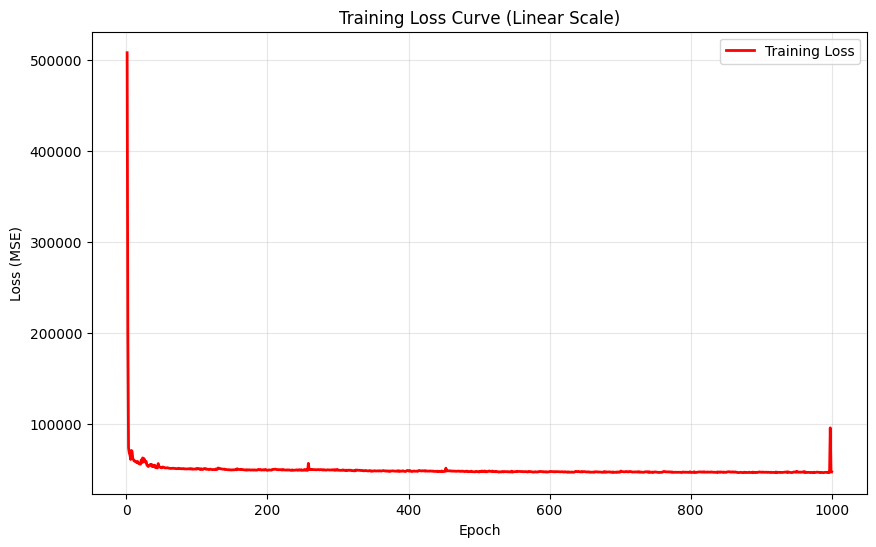

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, 'r-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Curve (Linear Scale)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Part IV. Testing

Test Loss (MSE): 48449.6632
Mean Absolute Error (MAE): 158.2500
Root Mean Squared Error (RMSE): 220.1128
R² Score: 0.8047
Mean Absolute Percentage Error (MAPE): 23.96%


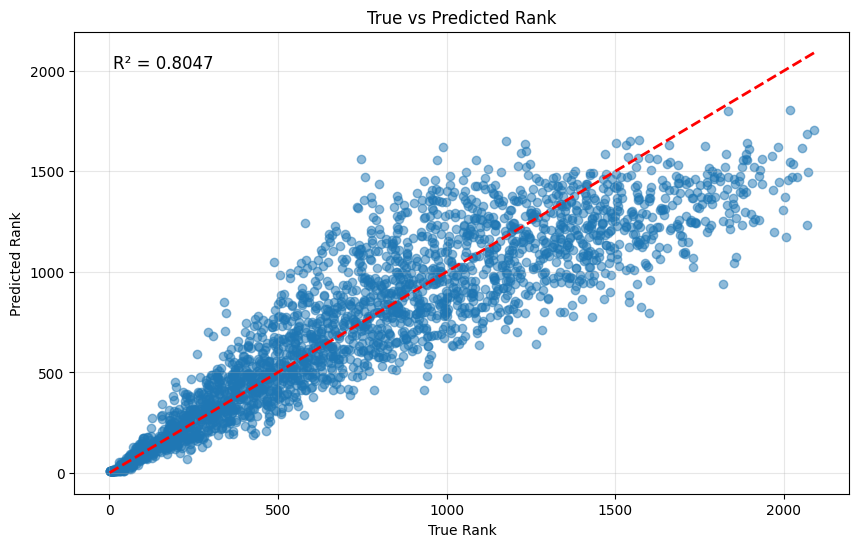

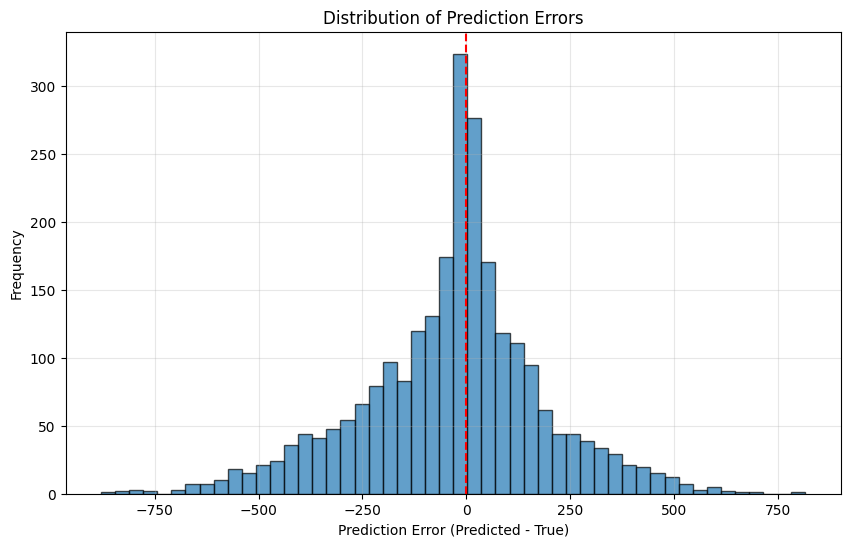


Performance by Rank Range:
Rank 1-100: 175 samples, MAE: 14.77
Rank 100-500: 731 samples, MAE: 75.95
Rank 500-1000: 814 samples, MAE: 169.99
Rank 1000-2000: 789 samples, MAE: 248.04

Sample Predictions:
True:  763.0, Predicted:  741.2, Error:  -21.8
True:  469.0, Predicted:  646.3, Error:  177.3
True:  812.0, Predicted:  573.2, Error: -238.8
True:  577.0, Predicted:  557.5, Error:  -19.5
True: 1219.0, Predicted: 1219.9, Error:    0.9
True:  348.0, Predicted:  455.8, Error:  107.8
True:  334.0, Predicted:  228.6, Error: -105.4
True:  680.0, Predicted:  567.0, Error: -113.0
True: 1051.0, Predicted: 1227.2, Error:  176.2
True:  974.0, Predicted:  966.1, Error:   -7.9


In [16]:
# 定义测试函数
def test_model(model, test_loader, criterion, device):
    model.eval()  # 设置为评估模式
    test_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():  # 关闭梯度计算
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            # 保存预测结果和真实标签
            all_predictions.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算平均损失
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    return avg_test_loss, all_predictions, all_labels

# 执行测试
test_loss, predictions, true_labels = test_model(model, test_loader, criterion, device)

print(f"Test Loss (MSE): {test_loss:.4f}")

# 计算其他评估指标
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# 转换为numpy数组
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# 计算各种评估指标
mae = mean_absolute_error(true_labels, predictions)
rmse = np.sqrt(test_loss)  # 因为test_loss是MSE
r2 = r2_score(true_labels, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 计算平均绝对百分比误差
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(true_labels, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 可视化预测结果 vs 真实值
plt.figure(figsize=(10, 6))
plt.scatter(true_labels, predictions, alpha=0.5)
plt.plot([true_labels.min(), true_labels.max()], 
         [true_labels.min(), true_labels.max()], 'r--', lw=2)
plt.xlabel('True Rank')
plt.ylabel('Predicted Rank')
plt.title('True vs Predicted Rank')
plt.grid(True, alpha=0.3)

# 添加R²值到图中
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')

plt.show()

# 绘制误差分布图
errors = predictions - true_labels
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error (Predicted - True)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

# 分析排名区间的性能
def analyze_by_rank_range(true_labels, predictions, ranges):
    results = {}
    for i, (lower, upper) in enumerate(ranges):
        mask = (true_labels >= lower) & (true_labels < upper)
        if np.sum(mask) > 0:
            mae_range = mean_absolute_error(true_labels[mask], predictions[mask])
            results[f'{lower}-{upper}'] = {
                'count': np.sum(mask),
                'mae': mae_range
            }
    return results

# 定义排名区间
rank_ranges = [(1, 100), (100, 500), (500, 1000), (1000, 2000)]
range_results = analyze_by_rank_range(true_labels, predictions, rank_ranges)

print("\nPerformance by Rank Range:")
for range_name, metrics in range_results.items():
    print(f"Rank {range_name}: {metrics['count']} samples, MAE: {metrics['mae']:.2f}")

# 检查一些具体的预测示例
print("\nSample Predictions:")
indices = np.random.choice(len(true_labels), 10, replace=False)
for i in indices:
    print(f"True: {true_labels[i]:6.1f}, Predicted: {predictions[i]:6.1f}, "
          f"Error: {predictions[i] - true_labels[i]:6.1f}")